<a href="https://colab.research.google.com/github/harvard-visionlab/psy1406/blob/main/2022/psy1406_project01_alexnet_image_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview



*   This notebook will allow you to probe the representations of a deep, convolutional neural network (AlexNet) that has been trained either on ImageNet or on "Stylized Imagenet" (from the Geirhos "texture-bias" paper). The model trained on ImageNet is more texture-biased, and the one trained on Stylized Imagenet is more shape-biased.

*   Specifically, you can upload images, pass them through your deep neural network, and then evaluate how similar the images are in different "feature spaces" of the model (from early convolutional layers, to the fully connected layers, and finally at the output layer).

* Similarity is computed by taking the measuring the activation for each unit in a model layer to each image. For each pair of images, we then compute the correlation (pearsonr) between the activations for the two images, giving us a measure of "similarity" in responses to the two images in that layer.

# Goals
Your goal is to test your some of your own ideas about shape vs. texture, and what kind of shape information is actually captured by the shape-biased model. In general, you might explore what kind of model (texture-biased vs. shape-biased) does a better job of predicting your own intuitive sense of perceptual similarity  (using your self as proxy for "what humans see"). For example...
- You can choose a "target image" and compare it to several variants, ranked by which one looks more similar to the target to you. Then you can ask whether the rank order is better matched by the texture-biased vs. shape-biased model.
- Can you find a comparison that seems more texture-depedendent, and does the texture-biased model do a better job in this case?
- Is the shape-biased model more sensitive to 2D depth cues (like the one discussed in the "Line Drawings" paper we read?)
- It might be interesting to test these texture-biased and shape-biased models on some of the questions about faces that are posed in the other notebook (psy1406_project01_facenet_image_similarity.ipynb). For instance, it's possible that shape-biased models do a better job of predicting face-similarity than texture-biased models.


# Instructions
* The cells of this notebook are intended to be run in order. To run a cell, place the cursor in the cell and hit "Shift + Enter".
* You can also run entire sections by collapsing the section (arrows on the left of header cells), and click the "play button" to run all the cells in that section.
* You'll be turning in a copy of this notebook and some powerpoint slides (see Step 9 below). Your powerpoint presentation can literally be just two slides, a screenshot of the images you use, and screenshot of the results. No text needed, because in class we'll just put up your slides and you'll talk about what images you presented, why you presented them (what question you were trying to answer), and then show us the results and what you think it means. You might need two slides for each variation you test (e.g., if you tested a hypothesis with a new image set, take a snapshot of the images and results.


# Step 0 - General Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!mkdir -p ./images
!wget -c https://www.dropbox.com/s/7tqlvb69lvx570h/BaldBear.jpg -q --show-progress -O./images/BaldBear.jpg
!wget -c https://www.dropbox.com/s/nbct96tf4oqnr2q/BrownBear2.jpg -q --show-progress -O ./images/BrownBear.jpg
!wget -c https://www.dropbox.com/s/65p68g331kby809/Gorilla.jpg -q --show-progress -O ./images/Gorilla.jpg
!wget -c https://www.dropbox.com/s/3d4kn24pu8zehye/car.jpg -q --show-progress -O ./images/car.jpg
!wget -c https://www.dropbox.com/s/be1hkifaz8u04y9/DiCaprio_Anchor.jpg -q --show-progress -O ./images/DiCaprio_Anchor.jpg
!wget -c https://www.dropbox.com/s/xn3y46bpccopdl7/DiCaprio_HardNegative.jpg -q --show-progress -O ./images/DiCaprio_HardNegative.jpg
!wget -c https://www.dropbox.com/s/8londclzzyj3oji/DiCaprio_NegativeClooney.jpg -q --show-progress -O ./images/DiCaprio_NegativeClooney.jpg
!wget -c https://www.dropbox.com/s/ddlfya3368jdhci/DiCaprio_Positive.jpg -q --show-progress -O ./images/DiCaprio_Positive.jpg

!wget -c https://www.dropbox.com/s/m4lerdmpmrh2ap0/cat2-elephant1.png -q --show-progress -O ./images/cat2-elephant1.png
!wget -c https://www.dropbox.com/s/8mdw5m8y7tebyz3/cat3-elephant2.png -q --show-progress -O ./images/cat3-elephant2.png
!wget -c https://www.dropbox.com/s/3v1u5pedycehl4i/elephant3-cat2.png -q --show-progress -O ./images/elephant3-cat2.png
!wget -c https://www.dropbox.com/s/6dpxbxx10kb8g5j/elephant7-cat1.png -q --show-progress -O ./images/elephant7-cat1.png

!wget -c https://www.dropbox.com/s/qybtxl9oq48s2qb/cat7_greyscale.png -q --show-progress -O ./images/cat7_greyscale.png
!wget -c https://www.dropbox.com/s/p03ag7yrkwvg9zw/cat7_original.png -q --show-progress -O ./images/cat7_original.png
!wget -c https://www.dropbox.com/s/4a0486jusff6a6v/cat7_silhouette_filled.png -q --show-progress -O ./images/cat7_silhouette_filled.png
!wget -c https://www.dropbox.com/s/84oeiyxfn1s0jf6/cat7-elephant1_nomask.png -q --show-progress -O ./images/cat7-elephant1_nomask.png
!wget -c https://www.dropbox.com/s/vzr574fapff56g8/elephant1.png -q --show-progress -O ./images/elephant1.png
!wget -c https://www.dropbox.com/s/7jdy08qxqtj8loa/cat7-elephant1_mask.png -q --show-progress -O ./images/cat7-elephant1_mask.png
!wget -c https://www.dropbox.com/s/8bkstj7xpl71aap/cat7_original_small.png -q --show-progress -O ./images/cat7_original_small.png

./images/BaldBear.j 100%[===================>]  96.21K   293KB/s    in 0.3s    
./images/BrownBear. 100%[===================>] 221.81K  --.-KB/s    in 0.04s   
./images/Gorilla.jp 100%[===================>] 145.40K  --.-KB/s    in 0.03s   
./images/car.jpg    100%[===================>]  84.13K   237KB/s    in 0.4s    
./images/DiCaprio_A 100%[===================>]  62.19K   217KB/s    in 0.3s    
./images/DiCaprio_H 100%[===================>]  51.92K  --.-KB/s    in 0.02s   
./images/DiCaprio_N 100%[===================>]   3.50M  3.03MB/s    in 1.2s    
./images/DiCaprio_P 100%[===================>]  60.30K  --.-KB/s    in 0.02s   
./images/cat2-eleph 100%[===================>] 109.97K  --.-KB/s    in 0.03s   
./images/cat3-eleph 100%[===================>] 108.09K  --.-KB/s    in 0.03s   
./images/elephant3- 100%[===================>] 108.60K  --.-KB/s    in 0.03s   
./images/elephant7- 100%[===================>] 104.35K  --.-KB/s    in 0.03s   
./images/cat7_greys 100%[===============

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
%config InlineBackend.figure_format='retina'
# %matplotlib notebook
%matplotlib inline
sns.set(rc={'figure.figsize':(15.7,8.27)})
np.set_printoptions(suppress=True)

In [4]:
import os
import numpy as np
import pandas as pd
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from glob import glob
from pathlib import Path
from PIL import Image
from pprint import pprint
from collections import OrderedDict

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from pdb import set_trace

class ImageListDataset(Dataset):
    """"""

    def __init__(self, imgs, transform=None):
        self.root_dir = None
        self.files = imgs
        self.transform = transform

    def __getitem__(self, index):
        im = Image.open(self.files[index]).convert('RGB')
        if self.transform:
            im = self.transform(im)

        return im, 0, index

    def __len__(self):
        return len(self.files)

    def __repr__(self):
        _repr_indent = 4
        head = "Dataset " + self.__class__.__name__
        body = ["Number of Images: {}".format(self.__len__())]
        if self.root_dir is not None:
            body.append("Root location: {}".format(self.root_dir))
        if hasattr(self, "transform") and self.transform is not None:
            body += [repr(self.transform)]
        lines = [head] + [" " * _repr_indent + line for line in body]
        return '\n'.join(lines)


def get_dataset(image_pairs, root_dir=Path('images'), crop=False):
    if crop:
      transform = transforms.Compose([
        transforms.Resize((224)),
        transforms.CenterCrop(224)
      ])
    else:
      transform = transforms.Compose([
        transforms.Resize((224, 224)),
      ])
    
    imgs = [root_dir/img for imgs in image_pairs for img in imgs]
    dataset = ImageListDataset(imgs=imgs, transform=transform)

    return dataset


def show_grid(dataset):
    imgs = []
    for image_num in range(0, len(dataset), 2):
        imgs.append(np.hstack(
            [np.array(dataset[image_num][0]), np.array(dataset[image_num+1][0])]))
    imgs = np.vstack(imgs)

    return Image.fromarray(imgs)



alexnet_pytorch_blocks = OrderedDict([
    ('Conv1', ['features.0','features.1','features.2']),
    ('Conv2', ['features.3','features.4','features.5']),
    ('Conv3', ['features.6','features.7']),
    ('Conv4', ['features.8','features.9']),
    ('Conv5', ['features.10','features.11','features.12']),
    ('', ['avgpool']),
    ('fc6', ['classifier.0','classifier.1','classifier.2']),
    ('fc7', ['classifier.3','classifier.4','classifier.5']),
    ('fc8', ['classifier.6']),
])

def plot_df(df, pairs=[0,1,2], title='', blocks=None, legend_loc=(0.25, 0.80), group_by='pair_num', ceiling=1, ylabel='correlation', legend_color=(0.95,0.95,0.95,1.0)):
    
    if pairs is None:
        #ax = plot_data(df, title, ymax=1.10, ymin=-0.20, hue=group_by, ylabel=ylabel)
        ax = plot_data(df[df.pair_num.isin(pairs)], title, ymax=1.10, ymin=-0.20, hue=group_by, ylabel=ylabel)
    else:
        ax = plot_data(df[df.pair_num.isin(pairs)], title, ymax=1.10, ymin=-0.20, hue=group_by, ylabel=ylabel)
    
    if blocks:
        draw_bg(blocks, ypos=1.03, legend_loc=legend_loc)
    
    L = ax.legend()
    legend_labels = []        
    
    for pair in pairs:
        label = df[df.pair_num == pair].iloc[0].image1.replace('.jpg', '') + '_vs_' + df[df.pair_num == pair].iloc[0].image2.replace('.jpg', '')
        legend_labels.append(label)
    for label_num, label in enumerate(legend_labels):
        if label is not None: L.get_texts()[label_num].set_text(label)

    L.set_bbox_to_anchor(legend_loc)    

    return ax

def plot_data(df, title, ymax=.50, ymin=0.0, hue=None, ylabel='correlation'):
    sns.set(rc={'figure.figsize':(16.7,8.27)})
    sns.set_style("whitegrid", {'axes.grid' : False})
    ax = sns.lineplot(x="layer", y="y", hue=hue, data=df, linewidth=2)
    ax.set_title(title, fontsize=24);
    ax.set_ylabel(ylabel, fontsize=24, labelpad=15);
    ax.set_xlabel("layer", fontsize=24, labelpad=20);
    ax.set_ylim([ymin, ymax])
    plt.xticks(rotation=90);
    
    return ax

def draw_bg(blocks, ypos=0.475, alpha_b=.20, alpha_g=.15, legend_loc=(0.79, 0.80)):
    if blocks == None: return
    c = 0
    for idx, (block_name, layers) in enumerate(blocks.items()):
        n_layers = len(layers)
        for i in range(c, c+n_layers):
            if idx % 2 == 0:
                plt.axvspan(i-.5, i+.5, facecolor='b', alpha=alpha_b, lw=0)
            else:
                plt.axvspan(i-.5, i+.5, facecolor='gray', alpha=alpha_g, lw=0)
        plt.text(c+(n_layers)/2-.5, ypos, block_name, fontdict=None, fontsize=16, ha='center', va='center')
        c += n_layers
    plt.legend(facecolor=(0.95,0.95,0.95,1.0), bbox_to_anchor=legend_loc) 
    
def plot(df, legend_loc=(1.05, 0.70)):
    df['y'] = df['r']
    layer_name = lambda x: "{:02d}_{}".format(x.layer_num,x.layer_type.replace("BatchNorm2d","Norm").replace("GroupNorm", "Norm"))
    df['layer'] = df[['layer_num','layer_type']].apply(layer_name, axis=1)
    
    blocks = alexnet_pytorch_blocks
    
    pairs = df.pair_num.unique()
    
    ax = plot_df(df, blocks=blocks, pairs=pairs, legend_loc=legend_loc)

    return ax


In [5]:
import pandas as pd
from scipy.stats import pearsonr
from fastprogress import master_bar, progress_bar
from collections import OrderedDict
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch

def get_layer(m, layers):
    layer = layers.pop(0)
    m = getattr(m, layer)
    if len(layers) > 0:
        return get_layer(m, layers)
    return m


def get_layers(model, parent_name='', layer_info=[]):
    for module_name, module in model.named_children():
        layer_name = parent_name + '.' + module_name
        if len(list(module.named_children())):
            layer_info = get_layers(module, layer_name, layer_info=layer_info)
        else:
            layer_info.append(layer_name.strip('.'))

    return layer_info


def get_layer_type(model, layer_name):
    m = get_layer(model, layer_name.split("."))
    return m.__class__.__name__


def convert_relu_layers(parent):
    for child_name, child in parent.named_children():
        if isinstance(child, nn.ReLU):
            setattr(parent, child_name, nn.ReLU(inplace=False))
        elif len(list(child.children())) > 0:
            convert_relu_layers(child)


def store_activations(model, layer_names):
    a = OrderedDict()
    for layer_num, layer_name in enumerate(layer_names):
        layer_type = get_layer_type(model.model, layer_name)
        X = model.retained_layer(layer_name)
        try:
          X = X.view(X.shape[0], -1)
        except:
          continue
        a[layer_name] = X
    return a


def compute_similarity(model, dataset):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # hook model
    layer_names = get_layers(model, parent_name='', layer_info=[])
    
    if not isinstance(model, InstrumentedModel):
        model = InstrumentedModel(model)
    for layer_name in layer_names:
        model.retain_layer(layer_name)

    model = model.to(device)
    model.eval()

    # create dataloader
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    dataset = ImageListDataset(imgs=dataset.files, transform=transform)
    dataloader = DataLoader(dataset, batch_size=1,
                            shuffle=False, num_workers=0, pin_memory=False)

    # compute similarity by layer
    df = pd.DataFrame(columns=['pair_num', 'image1', 'image2',
                               'layer_num', 'layer_name', 'layer_type', 'r'])
    pair_num = 0
    mb = master_bar(dataloader)
    for count, (imgs, labels, indexes) in enumerate(mb):
        with torch.no_grad():
            model(imgs.to(device))
        if count % 2 == 0:
            a1 = store_activations(model, layer_names)
            image1 = dataset.files[indexes].name
        if count % 2 == 1:
            a2 = store_activations(model, layer_names)
            image2 = dataset.files[indexes].name
            for layer_num, layer_name in enumerate(progress_bar(layer_names, parent=mb)):
                if layer_name not in a1 or layer_name not in a2: continue
                r = pearsonr(a1[layer_name].squeeze(),
                             a2[layer_name].squeeze())[0]
                layer_type = get_layer_type(model.model, layer_name)
                df = df.append({
                    "pair_num": pair_num,
                    "image1": image1,
                    "image2": image2,
                    "layer_num": layer_num,
                    "layer_name": layer_name,
                    "layer_type": layer_type,
                    "r": r,
                }, ignore_index=True)

            pair_num += 1

    df.pair_num = df.pair_num.astype(int)

    return df


In [6]:
"""
Read PyTorch model from .pth.tar checkpoint.
"""
import os
import sys
from collections import OrderedDict
import torch
import torchvision
import torchvision.models
from torch.utils import model_zoo
from pdb import set_trace 

def load_model(model_name):

    model_urls = {
            'resnet50_trained_on_SIN': 'https://bitbucket.org/robert_geirhos/texture-vs-shape-pretrained-models/raw/6f41d2e86fc60566f78de64ecff35cc61eb6436f/resnet50_train_60_epochs-c8e5653e.pth.tar',
            'resnet50_trained_on_SIN_and_IN': 'https://bitbucket.org/robert_geirhos/texture-vs-shape-pretrained-models/raw/60b770e128fffcbd8562a3ab3546c1a735432d03/resnet50_train_45_epochs_combined_IN_SF-2a0d100e.pth.tar',
            'resnet50_trained_on_SIN_and_IN_then_finetuned_on_IN': 'https://bitbucket.org/robert_geirhos/texture-vs-shape-pretrained-models/raw/60b770e128fffcbd8562a3ab3546c1a735432d03/resnet50_finetune_60_epochs_lr_decay_after_30_start_resnet50_train_45_epochs_combined_IN_SF-ca06340c.pth.tar',
            'alexnet_trained_on_stylized': 'https://visionlab-pretrainedmodels.s3.amazonaws.com/model_zoo/rgeirhos/alexnet_train_60_epochs_lr0.001-b4aa5238.pth.tar',
            'alexnet_trained_on_imagenet': 'https://download.pytorch.org/models/alexnet-owt-7be5be79.pth',
    }

    if "resnet50" in model_name:
        print("Using the ResNet50 architecture.")
        model = torchvision.models.resnet50(pretrained=False)
        checkpoint = model_zoo.load_url(model_urls[model_name])
    elif "vgg16" in model_name:
        print("Using the VGG-16 architecture.")
       
        # download model from URL manually and save to desired location
        filepath = "./vgg16_train_60_epochs_lr0.01-6c6fcc9f.pth.tar"

        assert os.path.exists(filepath), "Please download the VGG model yourself from the following link and save it locally: https://drive.google.com/drive/folders/1A0vUWyU6fTuc-xWgwQQeBvzbwi6geYQK (too large to be downloaded automatically like the other models)"

        model = torchvision.models.vgg16(pretrained=False)
        checkpoint = torch.load(filepath)

    elif "alexnet" in model_name:
        print("Using the AlexNet architecture.")
        model = torchvision.models.alexnet(pretrained=False)
        checkpoint = model_zoo.load_url(model_urls[model_name], map_location='cpu')
    else:
        raise ValueError("unknown model architecture.")

    state_dict = checkpoint["state_dict"] if "state_dict" in checkpoint else checkpoint
    state_dict = {k.replace(".module", ""): v for k,v in state_dict.items()}
    model.load_state_dict(state_dict)
    return model

In [7]:
'''
Utilities for instrumenting a torch model.

InstrumentedModel will wrap a pytorch model and allow hooking
arbitrary layers to monitor or modify their output directly.
'''

import torch
import numpy
import types
import copy
from collections import OrderedDict, defaultdict


class InstrumentedModel(torch.nn.Module):
    '''
    A wrapper for hooking, probing and intervening in pytorch Modules.
    Example usage:

    ```
    model = load_my_model()
    with inst as InstrumentedModel(model):
        inst.retain_layer(layername)
        inst.edit_layer(layername, ablation=0.5, replacement=target_features)
        inst(inputs)
        original_features = inst.retained_layer(layername)
    ```
    '''

    def __init__(self, model):
        super().__init__()
        self.model = model
        self._retained = OrderedDict()
        self._detach_retained = {}
        self._editargs = defaultdict(dict)
        self._editrule = {}
        self._hooked_layer = {}
        self._old_forward = {}
        if isinstance(model, torch.nn.Sequential):
            self._hook_sequential()

    def __enter__(self):
        return self

    def __exit__(self, type, value, traceback):
        self.close()

    def forward(self, *inputs, **kwargs):
        return self.model(*inputs, **kwargs)

    def retain_layer(self, layername, detach=True):
        '''
        Pass a fully-qualified layer name (E.g., module.submodule.conv3)
        to hook that layer and retain its output each time the model is run.
        A pair (layername, aka) can be provided, and the aka will be used
        as the key for the retained value instead of the layername.
        '''
        self.retain_layers([layername], detach=detach)

    def retain_layers(self, layernames, detach=True):
        '''
        Retains a list of a layers at once.
        '''
        self.add_hooks(layernames)
        for layername in layernames:
            aka = layername
            if not isinstance(aka, str):
                layername, aka = layername
            if aka not in self._retained:
                self._retained[aka] = None
                self._detach_retained[aka] = detach

    def stop_retaining_layers(self, layernames):
        '''
        Removes a list of layers from the set retained.
        '''
        self.add_hooks(layernames)
        for layername in layernames:
            aka = layername
            if not isinstance(aka, str):
                layername, aka = layername
            if aka in self._retained:
                del self._retained[aka]
                del self._detach_retained[aka]

    def retained_features(self, clear=False):
        '''
        Returns a dict of all currently retained features.
        '''
        result = OrderedDict(self._retained)
        if clear:
            for k in result:
                self._retained[k] = None
        return result

    def retained_layer(self, aka=None, clear=False):
        '''
        Retrieve retained data that was previously hooked by retain_layer.
        Call this after the model is run.  If clear is set, then the
        retained value will return and also cleared.
        '''
        if aka is None:
            # Default to the first retained layer.
            aka = next(self._retained.keys().__iter__())
        result = self._retained[aka]
        if clear:
            self._retained[aka] = None
        return result

    def edit_layer(self, layername, rule=None, **kwargs):
        '''
        Pass a fully-qualified layer name (E.g., module.submodule.conv3)
        to hook that layer and modify its output each time the model is run.
        The output of the layer will be modified to be a convex combination
        of the replacement and x interpolated according to the ablation, i.e.:
        `output = x * (1 - a) + (r * a)`.
        '''
        if not isinstance(layername, str):
            layername, aka = layername
        else:
            aka = layername

        # The default editing rule is apply_ablation_replacement
        if rule is None:
            rule = apply_ablation_replacement

        self.add_hooks([(layername, aka)])
        self._editargs[aka].update(kwargs)
        self._editrule[aka] = rule

    def remove_edits(self, layername=None):
        '''
        Removes edits at the specified layer, or removes edits at all layers
        if no layer name is specified.
        '''
        if layername is None:
            self._editargs.clear()
            self._editrule.clear()
            return

        if not isinstance(layername, str):
            layername, aka = layername
        else:
            aka = layername
        if aka in self._editargs:
            del self._editargs[aka]
        if aka in self._editrule:
            del self._editrule[aka]

    def add_hooks(self, layernames):
        '''
        Sets up a set of layers to be hooked.

        Usually not called directly: use edit_layer or retain_layer instead.
        '''
        needed = set()
        aka_map = {}
        for name in layernames:
            aka = name
            if not isinstance(aka, str):
                name, aka = name
            if self._hooked_layer.get(aka, None) != name:
                aka_map[name] = aka
                needed.add(name)
        if not needed:
            return
        for name, layer in self.model.named_modules():
            if name in aka_map:
                needed.remove(name)
                aka = aka_map[name]
                self._hook_layer(layer, name, aka)
        for name in needed:
            raise ValueError('Layer %s not found in model' % name)

    def _hook_layer(self, layer, layername, aka):
        '''
        Internal method to replace a forward method with a closure that
        intercepts the call, and tracks the hook so that it can be reverted.
        '''
        if aka in self._hooked_layer:
            raise ValueError('Layer %s already hooked' % aka)
        if layername in self._old_forward:
            raise ValueError('Layer %s already hooked' % layername)
        self._hooked_layer[aka] = layername
        self._old_forward[layername] = (layer, aka,
                                        layer.__dict__.get('forward', None))
        editor = self
        original_forward = layer.forward

        def new_forward(self, *inputs, **kwargs):
            original_x = original_forward(*inputs, **kwargs)
            x = editor._postprocess_forward(original_x, aka)
            return x
        layer.forward = types.MethodType(new_forward, layer)

    def _unhook_layer(self, aka):
        '''
        Internal method to remove a hook, restoring the original forward method.
        '''
        if aka not in self._hooked_layer:
            return
        layername = self._hooked_layer[aka]
        # Remove any retained data and any edit rules
        if aka in self._retained:
            del self._retained[aka]
            del self._detach_retained[aka]
        self.remove_edits(aka)
        # Restore the unhooked method for the layer
        layer, check, old_forward = self._old_forward[layername]
        assert check == aka
        if old_forward is None:
            if 'forward' in layer.__dict__:
                del layer.__dict__['forward']
        else:
            layer.forward = old_forward
        del self._old_forward[layername]
        del self._hooked_layer[aka]

    def _postprocess_forward(self, x, aka):
        '''
        The internal method called by the hooked layers after they are run.
        '''
        # Retain output before edits, if desired.
        if aka in self._retained:
            if self._detach_retained[aka]:
                self._retained[aka] = x.detach()
            else:
                self._retained[aka] = x
        # Apply any edits requested.
        rule = self._editrule.get(aka, None)
        if rule is not None:
            x = rule(x, self, **(self._editargs[aka]))
        return x

    def _hook_sequential(self):
        '''
        Replaces 'forward' of sequential with a version that takes
        additional keyword arguments: layer allows a single layer to be run;
        first_layer and last_layer allow a subsequence of layers to be run.
        '''
        model = self.model
        self._hooked_layer['.'] = '.'
        self._old_forward['.'] = (model, '.',
                                  model.__dict__.get('forward', None))

        def new_forward(this, x, layer=None, first_layer=None, last_layer=None):
            assert layer is None or (
                first_layer is None and last_layer is None)
            first_layer, last_layer = [str(layer) if layer is not None
                                       else str(d) if d is not None else None
                                       for d in [first_layer, last_layer]]
            including_children = (first_layer is None)
            for name, layer in this._modules.items():
                if name == first_layer:
                    first_layer = None
                    including_children = True
                if including_children:
                    x = layer(x)
                if name == last_layer:
                    last_layer = None
                    including_children = False
            assert first_layer is None, '%s not found' % first_layer
            assert last_layer is None, '%s not found' % last_layer
            return x
        model.forward = types.MethodType(new_forward, model)

    def close(self):
        '''
        Unhooks all hooked layers in the model.
        '''
        for aka in list(self._old_forward.keys()):
            self._unhook_layer(aka)
        assert len(self._old_forward) == 0


def apply_ablation_replacement(x, imodel, **buffers):
    if buffers is not None:
        # Apply any edits requested.
        a = make_matching_tensor(buffers, 'ablation', x)
        if a is not None:
            x = x * (1 - a)
            v = make_matching_tensor(buffers, 'replacement', x)
            if v is not None:
                x += (v * a)
    return x


def make_matching_tensor(valuedict, name, data):
    '''
    Converts `valuedict[name]` to be a tensor with the same dtype, device,
    and dimension count as `data`, and caches the converted tensor.
    '''
    v = valuedict.get(name, None)
    if v is None:
        return None
    if not isinstance(v, torch.Tensor):
        # Accept non-torch data.
        v = torch.from_numpy(numpy.array(v))
        valuedict[name] = v
    if not v.device == data.device or not v.dtype == data.dtype:
        # Ensure device and type matches.
        assert not v.requires_grad, '%s wrong device or type' % (name)
        v = v.to(device=data.device, dtype=data.dtype)
        valuedict[name] = v
    if len(v.shape) < len(data.shape):
        # Ensure dimensions are unsqueezed as needed.
        assert not v.requires_grad, '%s wrong dimensions' % (name)
        v = v.view((1,) + tuple(v.shape) +
                   (1,) * (len(data.shape) - len(v.shape) - 1))
        valuedict[name] = v
    return v


def subsequence(sequential, first_layer=None, last_layer=None,
                share_weights=False):
    '''
    Creates a subsequence of a pytorch Sequential model, copying over
    modules together with parameters for the subsequence.  Only
    modules from first_layer to last_layer (inclusive) are included.

    If share_weights is True, then references the original modules
    and their parameters without copying them.  Otherwise, by default,
    makes a separate brand-new copy.
    '''
    included_children = OrderedDict()
    including_children = (first_layer is None)
    for name, layer in sequential._modules.items():
        if name == first_layer:
            first_layer = None
            including_children = True
        if including_children:
            included_children[name] = layer if share_weights else (
                copy.deepcopy(layer))
        if name == last_layer:
            last_layer = None
            including_children = False
    if first_layer is not None:
        raise ValueError('Layer %s not found' % first_layer)
    if last_layer is not None:
        raise ValueError('Layer %s not found' % last_layer)
    if not len(included_children):
        raise ValueError('Empty subsequence')
    return torch.nn.Sequential(OrderedDict(included_children))


# Step 1 - upload Images

First you'll need to upload your images to this Colab computer. If you click on the folder along the left hand side, you'll see a list of folders/files. If you ran Step 0 above, it will have created a folder called "images" and within it you should see a few different images (e.g., DiCaprio_Anchor.jpg, DiCaprio_NegativeClooney.jpg, etc.).

You can add your own images by downloading them to your computer, then dragging and dropping them to the images folder.

In [8]:
# if you want to download directly from a url, you can modify this line
# just make sure to change both the url and the output file name
!wget -c https://www.dropbox.com/s/7tqlvb69lvx570h/BaldBear.jpg -q --show-progress -O./images/BaldBear.jpg

# Step 2 - specify image pairs

- Here we need to tell the program which pairs of images we want to compare.
- The program assumes each image is in the images folder.
- If the program fails to find your images, double check your filename (case sensitive!)


In [9]:
# this command will list all of the .jpg images in your folder
!ls images/*.jpg
!ls images/*.png

images/BaldBear.jpg	    images/DiCaprio_HardNegative.jpg
images/BrownBear.jpg	    images/DiCaprio_NegativeClooney.jpg
images/car.jpg		    images/DiCaprio_Positive.jpg
images/DiCaprio_Anchor.jpg  images/Gorilla.jpg
images/cat2-elephant1.png	  images/cat7_original_small.png
images/cat3-elephant2.png	  images/cat7_silhouette_filled.png
images/cat7-elephant1_mask.png	  images/elephant1.png
images/cat7-elephant1_nomask.png  images/elephant3-cat2.png
images/cat7_greyscale.png	  images/elephant7-cat1.png
images/cat7_original.png


In [10]:
# here we define a list [ ... ]
# with a comma-separated set of "tuples" ( ... )
# that define pairs of images to be compared

# e.g., 
image_pairs = [
    ('Image1.png', 'Image2.png'), # this line compares Image1 and Image2
    ('Image1.png', 'Image3.png'), # this line compares Image1 and Image3
]

# Let's start with a test using some of the "cue-conflict" stimuli from the geirhos paper
image_pairs = [
    ('cat7-elephant1_nomask.png', 'cat7_original.png'),
    ('cat7-elephant1_nomask.png', 'cat7_silhouette_filled.png'),
    ('cat7-elephant1_nomask.png', 'elephant1.png'),
]

# image_pairs = [
#     ('cat7-elephant1_mask.png', 'cat7_original.png'),
#     ('cat7-elephant1_mask.png', 'cat7_silhouette_filled.png'),
#     ('cat7-elephant1_mask.png', 'elephant1.png'),
# ]

# image_pairs = [
#     ('cat7-elephant1_mask.png', 'cat7_original.png'),
#     ('cat7-elephant1_mask.png', 'cat7_original_small.png'),
#     ('cat7-elephant1_mask.png', 'elephant1.png'),
# ]

image_pairs

[('cat7-elephant1_nomask.png', 'cat7_original.png'),
 ('cat7-elephant1_nomask.png', 'cat7_silhouette_filled.png'),
 ('cat7-elephant1_nomask.png', 'elephant1.png')]

# Step 3 - create a dataset for your image_pairs

In [11]:
dataset = get_dataset(image_pairs, crop=False)
dataset

Dataset ImageListDataset
    Number of Images: 6
    Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
)

The number of images should match the number of images in your list (duplicates of the same image are counted twice, so we have 4 images total).

# Step4 - visualize image pairs

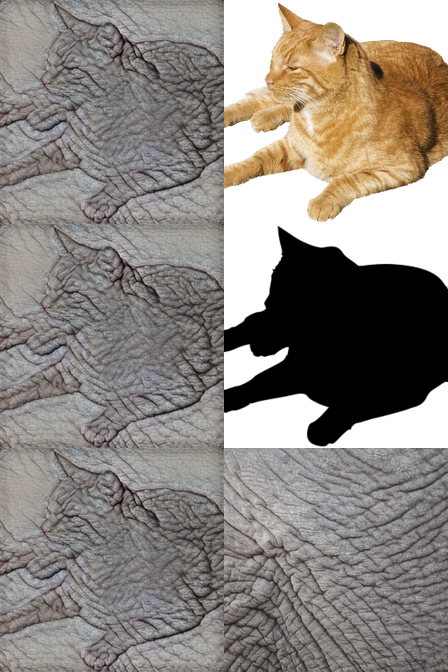

In [12]:
show_grid(dataset)

# Step5 - instantiate a deep neural network model

We're using Facebook's PyTorch library, and we'll load an AlexNet model that has been trained on ImageNet classification.

You can find a list of available models here:
https://pytorch.org/vision/stable/models.html

In [13]:
model = load_model('alexnet_trained_on_imagenet') # texture-biased
# model = load_model('alexnet_trained_on_stylized') # shape-biased
model

Using the AlexNet architecture.


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# Step6 - compute image similarity in each model layer

In [14]:
results = compute_similarity(model, dataset)
results.head()

,pair_num,image1,image2,layer_num,layer_name,layer_type,r
0,0,cat7-elephant1_nomask.png,cat7_original.png,0,features.0,Conv2d,0.398423
1,0,cat7-elephant1_nomask.png,cat7_original.png,1,features.1,ReLU,0.398423
2,0,cat7-elephant1_nomask.png,cat7_original.png,2,features.2,MaxPool2d,0.506153
3,0,cat7-elephant1_nomask.png,cat7_original.png,3,features.3,Conv2d,0.415819
4,0,cat7-elephant1_nomask.png,cat7_original.png,4,features.4,ReLU,0.415819


# Step7 - plot results

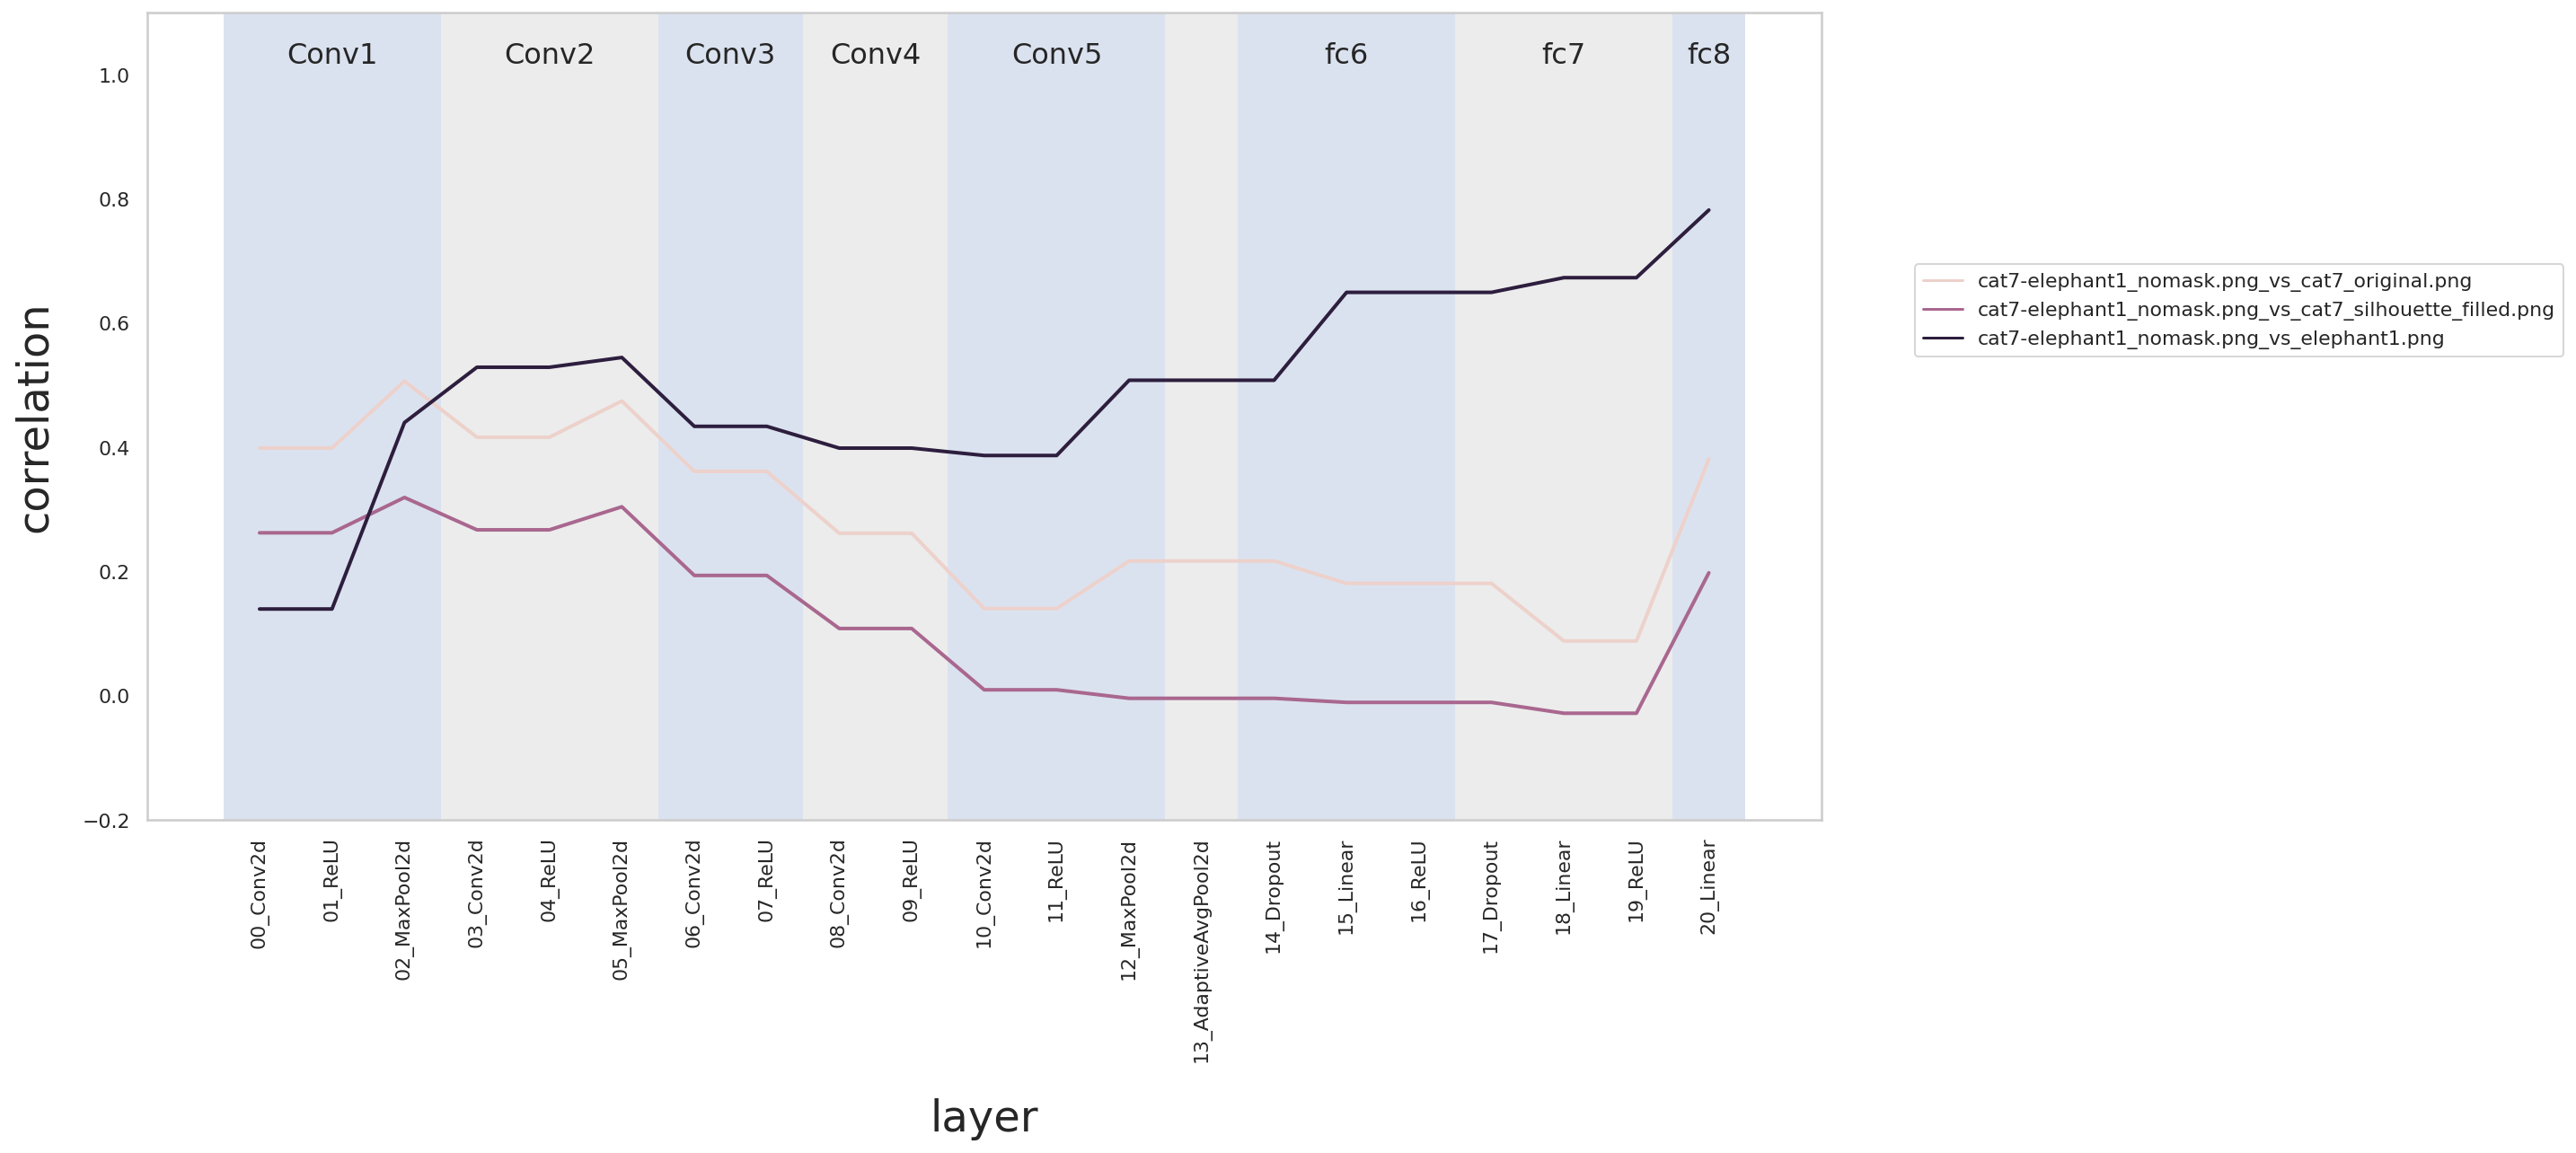

In [15]:
plot(results);

# Step8 - document your observations and conclusions

**observations**  
The BrownBear is more similar to the Gorilla than to the BaldBear in most model layers.

**interpretation**  
The model appears to "see" the BrownBear as more similar to a Gorilla than to the BaldBear.

**discussion**  
Does this agree with your subjective impression?
Actually, I found it hard to to decide. They looked about equal to me, but that does jibe with the fact that the differneces in similarity (between orange and blue lines in the figure) were small.

What conclusions would you draw about the network based on these results?
It does look like the network shows a bit of a texture bias (finding the gorilla more similar to the bear because of it's fur, even though the pose of the BaldBear is arguably more similar to the pose of the BrownBear).



# Step9 - Turn in your notebook and ppt slides.

**turn in your powerpoint slides**
- upload your powerpoint file, named Psy1406_YourLastName_YourFirstName_Project1.pptx to the course website

**turn in your notebook**
- Second, you should download a copy of your notebook to upload to the course website. Goto File -> Download -> Download .ipynb -> name file as: Psy1406_YourLastName_YourFirstName_Project1.ipynb
- upload your .ipynb file, along with your images, to the course website